**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [23]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix, issparse

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [24]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric="euclidean"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

        self.leaf_size = 30
        self.effective_metric_ = metric
        self.effective_metric_params_ = {}

    def fit(self, X, y):
        self.classes_, self._y = np.unique(y, return_inverse=True)
            
        self._fit_method = self.algorithm
        self._fit_X = X
        self.n_samples_fit_ = X.shape[0]

        if self._fit_method == 'brute':
            self._tree = None
        elif self._fit_method == 'kd_tree':
            self._tree = KDTree(X, self.leaf_size,
                                metric=self.effective_metric_,
                                **self.effective_metric_params_)

        return self

    def predict(self, X):
        _y = self._y.reshape((-1, 1))
        neigh_ind = self.kneighbors(X)

        mode, _ = stats.mode(_y[neigh_ind, 0], axis=1)
        mode = np.asarray(mode.ravel(), dtype=np.intp)
        y_pred = self.classes_.take(mode)
        
        return y_pred

    def kneighbors(self, X=None):
        results = None
        if self._fit_method == 'brute':
            if issparse(X):
                dist = pairwise_distances(X, self._fit_X, self.effective_metric_)
            else:
                dist = cdist(X, self._fit_X, self.effective_metric_)
            results = self._kneighbors_reduce_func(dist, 0, self.n_neighbors)
        elif self._fit_method == 'kd_tree':
            results = self._tree.query(X, k=self.n_neighbors)[1]
        else:
            raise ValueError("internal: _fit_method not recognized")

        return results

    def _kneighbors_reduce_func(self, dist, start, n_neighbors):
        sample_range = np.arange(dist.shape[0])[:, None]
        neigh_ind = np.argpartition(dist, n_neighbors - 1, axis=1)
        neigh_ind = neigh_ind[:, :n_neighbors]
        # argpartition doesn't guarantee sorted order, so we sort again
        neigh_ind = neigh_ind[
            sample_range, np.argsort(dist[sample_range, neigh_ind])]
        result = neigh_ind
        return result
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [25]:
iris = datasets.load_iris()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [27]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [30]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [32]:
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(metric=None, n_neighbors=2)

In [33]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [34]:
%time clf.fit(X_train, y_train)

Wall time: 1 ms


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [36]:
%time my_clf.fit(X_train, y_train)

Wall time: 1 ms


MyKNeighborsClassifier(metric=None, n_neighbors=2)

In [37]:
%time clf.predict(X_test)

Wall time: 4 ms


array([2, 2, 1, 0, 1, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0])

In [38]:
%time my_clf.predict(X_test)

Wall time: 3 ms


array([2, 2, 1, 0, 1, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [39]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [41]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [43]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


MyKNeighborsClassifier(algorithm='kd_tree', metric=None, n_neighbors=2)

In [44]:
%time clf.predict(X_test)

Wall time: 3 ms


array([1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1])

In [45]:
%time my_clf.predict(X_test)

Wall time: 2.96 ms


array([1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1])

In [46]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [146]:
newsgroups_train = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [152]:
train_data = newsgroups_train['data']
train_target = newsgroups_train['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [154]:
vect = CountVectorizer(max_df=.15, stop_words="english", max_features = 10_000, ngram_range = (1, 3))
vect.fit(train_data)
train_input_csr = vect.transform(train_data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [212]:
def cross_val_score2(input_csr, target, n_neighbors=1, algorithm='brute', metric='euclidean', n_splits=3):
    scores = []
    skf = StratifiedKFold(n_splits=n_splits)
    for train_idx, test_idx in skf.split(input_csr, target):
        X_train, X_test = input_csr[train_idx], input_csr[test_idx]
        y_train, y_test = target[train_idx], target[test_idx]
        my_clf = MyKNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm, metric=metric)
        my_clf.fit(X_train, y_train)
        my_clf_pred = my_clf.predict(X_test)
        scores.append(accuracy_score(y_test, my_clf_pred))
    return sum(scores)/len(scores)

In [214]:
cross_val_score2(train_input_csr, train_target, n_neighbors=1)

0.28760794153892905

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [134]:
def get_best_n_neighbors(input_csr, target, metric='euclidean'):
    scores = np.array([cross_val_score2(input_csr, target, n_neighbors=n_neighbors, metric=metric) for n_neighbors in range(1, 11)])
    idx = np.argmax(scores)
    return (idx + 1, scores[idx])

In [215]:
get_best_n_neighbors(train_input_csr, train_target)

(1, 0.28760794153892905)

In [216]:
x_values = range(1, 11)
y_values1 = [cross_val_score2(train_input_csr, train_target, n_neighbors=n_neighbors) for n_neighbors in x_values]

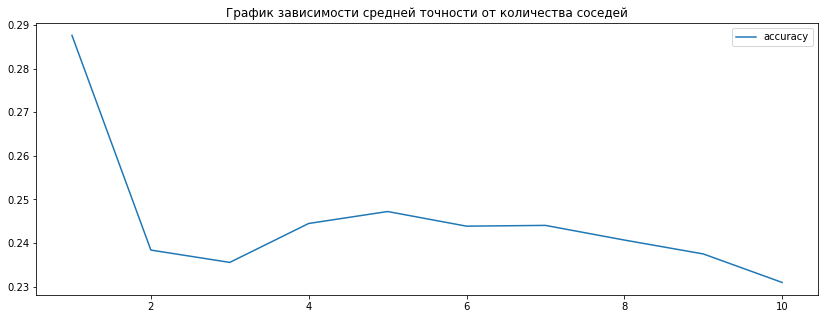

In [127]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
ax1.set_title("График зависимости средней точности от количества соседей")
plt.plot(x_values, y_values1, label="accuracy")
plt.legend()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [166]:
y_values2 = [cross_val_score2(train_input_csr, train_target, n_neighbors=n_neighbors, metric='cosine') for n_neighbors in x_values]

In [217]:
vect_tfidf = TfidfVectorizer(max_df=.15, stop_words="english", max_features = 10_000, ngram_range = (1, 3))          
vect_tfidf.fit(train_data)   
train_input_csr_tfidf = vect_tfidf.transform(train_data)  

In [175]:
y_values3 = [cross_val_score2(train_input_csr_tfidf, train_target, n_neighbors=n_neighbors, metric='cosine') for n_neighbors in x_values]

In [218]:
get_best_n_neighbors(train_input_csr_tfidf, train_target, metric='cosine')

(10, 0.6366458355185745)

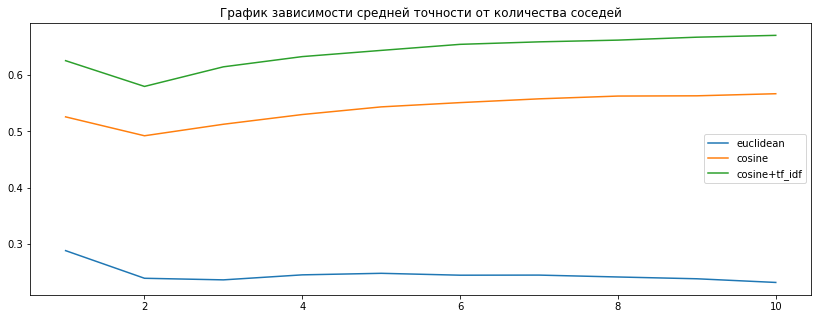

In [219]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
ax1.set_title("График зависимости средней точности от количества соседей")
plt.plot(x_values, y_values1, label="euclidean")
plt.plot(x_values, y_values2, label="cosine")
plt.plot(x_values, y_values3, label="cosine+tf_idf")
plt.legend()

Качество улучшилось при использовании косинусной меры +  TfIdf. Лучшая модель "cosine+tf_idf".

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [143]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [144]:
test_data = newsgroups_test['data']
test_target = newsgroups_test['target']

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [185]:
test_input_csr = vect_tfidf.transform(test_data)

In [191]:
y_values4 = []
for n in x_values:
    my_clf = MyKNeighborsClassifier(n_neighbors=n, metric='cosine')
    my_clf.fit(train_input_csr_tfidf, train_target)
    my_clf_pred = my_clf.predict(test_input_csr)
    y_values4.append(accuracy_score(test_target, my_clf_pred))

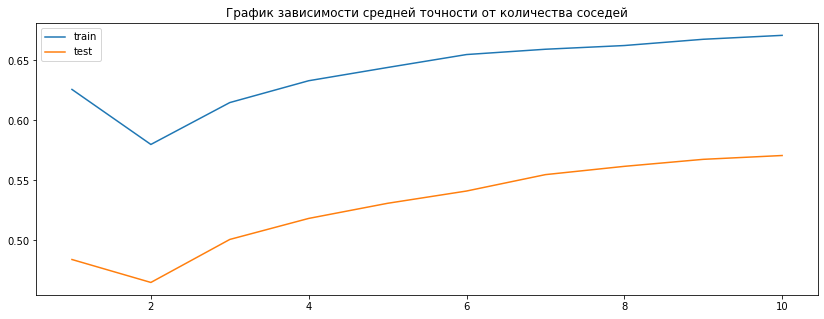

In [192]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
ax1.set_title("График зависимости средней точности от количества соседей")
plt.plot(x_values, y_values3, label="train")
plt.plot(x_values, y_values4, label="test")
plt.legend()

In [195]:
my_clf = MyKNeighborsClassifier(n_neighbors=10, metric='cosine')
my_clf.fit(train_input_csr_tfidf, train_target)
my_clf_pred = my_clf.predict(test_input_csr)
accuracy_score(test_target, my_clf_pred)

0.5707647371216145

Максимальная точность достигается при n_neighbors = 10.
Точность хуже, чем при кросс-валидации.
Вероятно, качество отличается из-за того, что словарь был построен только на основе train_data.

Попробуем сделать общий словарь и увеличить кол-во признаков.


In [234]:
all_data = list(train_data)
all_data.extend(test_data)

In [235]:
all_target = list(train_target)
all_target.extend(test_target)

In [255]:
vect_tfidf2 = TfidfVectorizer(max_df=.15, stop_words="english", max_features = 100_000, ngram_range = (1, 3))          
vect_tfidf2.fit(all_data)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.15,
                max_features=100000, min_df=1, ngram_range=(1, 3), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words='english',
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [256]:
test_input_csr2 = vect_tfidf2.transform(test_data)
train_input_csr2 = vect_tfidf2.transform(train_data)

In [257]:
my_clf2 = MyKNeighborsClassifier(n_neighbors=10, metric='cosine')
my_clf2.fit(train_input_csr2, train_target)
my_clf_pred2 = my_clf2.predict(test_input_csr2)
accuracy_score(test_target, my_clf_pred2)

0.6074083908656399

Точность стала лучше: 0.607 > 0.570.

In [258]:
y_values5 = [cross_val_score2(train_input_csr2, train_target, n_neighbors=n_neighbors, metric='cosine') for n_neighbors in x_values]

In [260]:
y_values6 = []
for n in x_values:
    my_clf6 = MyKNeighborsClassifier(n_neighbors=n, metric='cosine')
    my_clf6.fit(train_input_csr2, train_target)
    my_clf_pred6 = my_clf6.predict(test_input_csr2)
    accuracy_score(test_target, my_clf_pred6)
    y_values6.append(accuracy_score(test_target, my_clf_pred6))

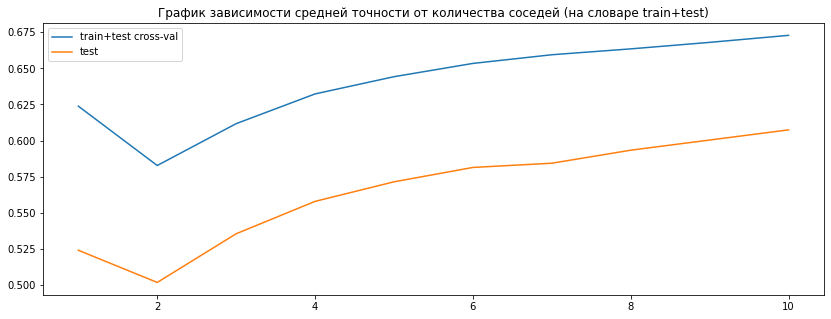

In [261]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
ax1.set_title("График зависимости средней точности от количества соседей (на словаре train+test)")
plt.plot(x_values, y_values5, label="train+test cross-val")
plt.plot(x_values, y_values6, label="test")
plt.legend()